In [1]:
from input import *



# Modellverifizierung

In diesem Kapitel werden die beiden Versuche aus der Vorarbeit @gitz_ansatze_2024 mit einem Drehfedermodell, gemäss dem Beschrieb in @sec-modellvorstellung, nachgerechnet. Dazu wird eine feine Stabunterteilung gewählt, um das Verformungsverhalten präzise abzubilden. Detaillierte Berechnungen und Versuchsbeschriebe, welche als Grundlagen für die Modellierung dienen, sind in @gitz_ansatze_2024 zu finden. Grundsätzlich gilt, dass für den Betonstahl bilineare Spannungs-Dehnungs-Beziehungen hinterlegt sind und für den Beton ein elastisch-ideal-plastisches Gesetz mit Berücksichtigung der Zugfestigkeit.

## Dreipunktbiegeversuch

Der Dreipunktbiegeversuch ist der dritte Versuch der Serie A in der zweiten Versuchsanordnung aus @jager_versuche_2006, kurz betitelt mit A3V2. Dieser ist mit einer durchegehenden Längsbewehrung im Zugbereich bewehrt. Die Schubdübel sind nicht durchgängig verlegt. Dargestellt ist das Bewehrungslayout in der @fig-bewehrung_a3v2.

![Bewehrunslayout des Versuchs A3V2, Zeichnung entnommen aus @jager_versuche_2006](../imgs/bewehrung_a3v2.svg){#fig-bewehrung_a3v2}

Das statische System des Versuchs ist in @fig-system_a3v2 dargestellt. Das Eigengewicht wird vernachlässigt, da die Verformungsmessungen nach dem Einbau des Versuchs beginnen, bzw. erst bei Belastungsbeginn mit der Einzellast.


![Statisches System des Versuchs A3V2](../imgs/A3V2_system.svg){#fig-system_a3v2}


Die @fig-qs_a3v2 zeigt den Querschnitt des Versuchs mit der entsprechenden Bewehrungsführung. 

![Querschnitt des Versuchs A3V2, Zeichnung entnommen aus @gitz_ansatze_2024](../imgs/QS_Versuch_A3.svg){#fig-qs_a3v2}


### Drehfedercharakteristik

Als erster Eingabeparamter in das Drehfedermodell dient die Momenten-Krümmungs-Beziehung. Für den Querschnitt ist die nicht-lineare Beziehung in der @fig-mchi_a3v2 gezeigt. Detaillierte Berechnungen sind in der Vorarbeit @gitz_ansatze_2024 zu finden.

In [2]:
# Read the text file using numpy
M_array = np.loadtxt("docs/M_A3V2.txt") * N * m
chi_array = np.loadtxt("docs/chi_A3V2.txt") / m

chi_zugversteifung_1_array = chi_array.copy()

chi_zugversteifung_1_array[2] = chi_array[2] - 0.00131 / m
chi_zugversteifung_1_array[3] = chi_array[3] - 0.00131 / m

c:\Users\Pascal Gitz\miniconda3\envs\calcs11\Lib\site-packages\matplotlib\cbook.py:1345: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return np.asarray(x, float)


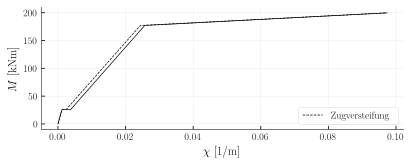

In [3]:
# | label: fig-mchi_a3v2
# | fig-cap: "Momenten-Krümmungs-Beziehung des Dreipunktbiegeversuchs, übernommen aus @gitz_ansatze_2024"


chi_interpolated = np.linspace(0, max(chi_array), 1000)
# Linear interpolation in M_array
M_interpolated = np.interp(chi_interpolated, chi_array, M_array)
M_1_interpolated = np.interp(chi_interpolated, chi_zugversteifung_1_array, M_array)
# Plot the interpolated data
plt.plot(
    chi_interpolated,
    M_1_interpolated.to(kN * m),
    color="black",
    linestyle="dashed",
    label="Zugversteifung",
)

plt.plot(chi_interpolated, M_interpolated.to(kN * m), color="black")
# plt.fill_between(chi_interpolated, M_interpolated / 10**3, color="black", alpha=0.1)
plt.xlabel("$\chi$ [1/m]")
plt.ylabel("$M$ [kNm]")
plt.legend()
plt.savefig("imgs/M_chi_A3V2.svg")
plt.show()

In [4]:
l_element = 0.01 * m

#### Versatzmass

Ein Ansatz zur Berücksichtigung des Versatzmass ist es ein Versatzmoment mit dem maximalen Querkraftwiderstand zu bestimmen. Die Momenten-Krümmungs-Beziehung kann durch diesen Wert vermindert werden und folglich weicher gestaltet werden.

In [5]:
%%render 1
theta_c3_A3V2 = (34.3 * deg)
V_Rd_A3V2 = (320*kN)
z_A3V2 = (140 * mm)

Delta_M_A3V2 = V_Rd_A3V2 /tan(theta_c3_A3V2) / 2 * (z_A3V2).to(m)


<IPython.core.display.Latex object>

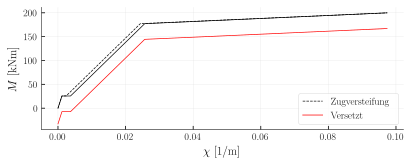

In [6]:
# | label: fig-mchi_a3v2_versatz
# | fig-cap: "Momenten-Krümmungs-Beziehung des Dreipunktbiegeversuchs mit Versatzmass"


plt.plot(
    chi_interpolated,
    M_1_interpolated.to(kN * m),
    color="black",
    linestyle="dashed",
    label="Zugversteifung",
)

plt.plot(chi_interpolated, M_interpolated.to(kN * m), color="black")
plt.plot(
    chi_interpolated,
    M_interpolated.to(kN * m) - Delta_M_A3V2,
    color="red",
    label="Versetzt",
)
# plt.fill_between(chi_interpolated, M_interpolated / 10**3, color="black", alpha=0.1)
plt.xlabel("$\\chi$ [1/m]")
plt.ylabel("$M$ [kNm]")
plt.legend()
plt.savefig("imgs/M_chi_A3V2_versatz.svg")
plt.show()

### Wegfedercharakteristik

#### Schiebung

Als Grundlage zur Modellierung der Schubverformungen dient das Spannungsfeld-Modell in @fig-spannungsfelder_a3v2. Dabei wird vorausgesetzt, dass sämtliche Dehnung des Systems in vertikaler Richtung lediglich aus der Stabdehnung der Schubbewehrung erfolgt. Das Ziel ist es ein Kraft-Verformungs-Diagramm, bzw. eine Wegfedercharakteristik zu ermitteln.

![Einteilung in Spannungsfelder des Versuchs A3V2, Zeichnung entnommen aus @gitz_ansatze_2024](../imgs/Spannungsfelder_flach.svg){#fig-spannungsfelder_a3v2}

Durch die Einteilung in Spannungsfelder kann die Anzahl an mitwirkenden Schubdübeln bestimmt werden. Mit der Querschnittsfläche der mitwirkenden Dübel kann das nicht-lineare Spannungs-Dehnungs-Verhalten in ein Kraft-Verformungs-Diagramm bzw. in eine Wegfedercharakteristik umgewandelt werden. Die bekannte Dehnung aus der Stahlkennlinie wird über den Hebelarm der inneren Kräfte zu einer Verformung umgewandelt. Wichtig dabei ist die Elementlänge der biegesteifen Stäbe im FEM-Modell. Dazu wird die Verformung um den Faktor gemäss der folgenden Gleichung reduziert, bzw. die Steifigkeit der Feder um diesen Faktor erhöht. 

$$
\gamma_{E} = \frac{z \cdot \cot(\theta)}{n_{E}}
$$

$n_{E}$ steht für die Anzahl steifer Stabelemente

In [7]:
sigma_w_A3V2 = np.array([0.0, 546, 630]) * N / mm**2

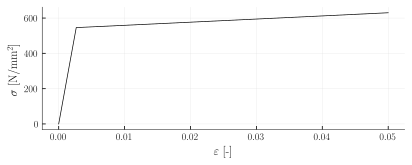

In [8]:
# | label: fig-sigma-eps-a3v2
# | fig-cap: "Spannungs-Dehnungs-Beziehung der Schubbewehrung, übernommen aus @gitz_ansatze_2024"


epsilon_w_A3V2 = np.array([0.0, 546 / 205000, 0.05])

plt.plot(epsilon_w_A3V2, sigma_w_A3V2, color="black")
# plt.fill_between(to_float(epsilon_w_A3V2), sigma_w_A3V2, color="black", alpha=0.1)
plt.xlabel("$\\varepsilon$ [-]")
plt.ylabel("$\\sigma$ [N/mm$^2$]")
plt.savefig("imgs/sigma_epsilon_A3V2.svg")

plt.show()

Folgend sind die Parameter zur Bestimmung der Wegfedercharakteristik in vertikaler Richtung gezeigt. Der gewählte Neigungswinkel der Spannungsfelder $/theta_{c3}$ gilt grundsätzlich nur im Bruchzustand. Als Approximation wird die daraus bestimmte Wegfedercharakteristik für sämtliche Laststufen angesetzt. Dies führt zu Abweichungen im Lastniveau unterhalb der Traglast, sofern die Schubverformung einen signifikanten Einfluss an der der Gesamtverformung liefern.

In [9]:
%%render params

Diam_sw_A3V2 = (6 * mm)
S_sw_A3V2 = (80 * mm)
b_w_A3V2 = (800 * mm)
E_sw_A3V2 = (205000 * N / mm**2)
E_sh_A3V2 = (sigma_w_A3V2[-1] - sigma_w_A3V2[-2]) / (epsilon_w_A3V2[-1] - epsilon_w_A3V2[-2])



<IPython.core.display.Latex object>

Die Querschnittsfläche der Schubbewehrung und der Bewehrungsgehalt bestimmt sich zu:

In [10]:
%%render 2

A_sw_A3V2 = 7 * (Diam_sw_A3V2 / 2) ** 2 * pi
a_sw_A3V2 = A_sw_A3V2 * (1000 * mm) / S_sw_A3V2 / m
rho_sw_A3V2 = (a_sw_A3V2 / b_w_A3V2).to(percent)


<IPython.core.display.Latex object>

In [11]:
F_w_A3V2 = sigma_w_A3V2 * 3 * A_sw_A3V2
# F_w_A3V2 = sigma_w_A3V2 * a_sw_A3V2 * z_A3V2 * sp.cot(theta_c3_A3V2)

E_s_A3V2 = sigma_w_A3V2 / epsilon_w_A3V2

c:\Users\Pascal Gitz\miniconda3\envs\calcs11\Lib\site-packages\pint\facets\plain\quantity.py:976: RuntimeWarning: invalid value encountered in divide
  magnitude = magnitude_op(self._magnitude, other_magnitude)


Der Reduktionsfaktor bestimmt sich zu:

In [12]:
%%render symbolic
gamma_E_A3V2 = z_A3V2 * 1/tan(theta_c3_A3V2) / (l_element).to(mm)


<IPython.core.display.Latex object>

In [13]:
%%render params 0

gamma_E_A3V2

<IPython.core.display.Latex object>

In [14]:
u_sw_A3V2 = epsilon_w_A3V2 * z_A3V2 / gamma_E_A3V2

Die @fig-wegfeder-schub-a3v2 zeigt das Kraft-Verformungs-Verhalten für die Gelenke des Stabmodells in vertikaler Richtung.

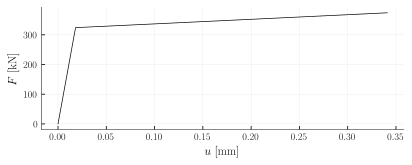

In [15]:
# | label: fig-wegfeder-schub-a3v2
# | fig-cap: "Berechnete Wegfedercharakteristik des Schubgelenks vom Versuch A3V2"


plt.plot(u_sw_A3V2, F_w_A3V2.to(kN), color="black")
# plt.fill_between(u_sw_A3V2, F_w_A3V2.to(kN), color="black", alpha=0.1)
plt.xlabel("$u$ [mm]")
plt.ylabel("$F$ [kN]")
plt.show()

### Versuchsvergleich

Mit den bestimmten Federcharakteristiken kann die Biegelinie des Systems ermittelt werden unter Berücksichtigung der Schub- und Biegeverformungen auf nicht-linearen Grundlagen. Die @fig-fwa3v2 zeigt das Last-Verformungs-Diagramm des Systems am Punkt $w_1$. Das Modell beschreibt den Verformungsverlauf zufriedenstellend.

In [16]:
# Versuch Jaeger
w_1_versuch_A3V2 = np.array(
    [2.6, 10.2, 10.3, 11.5, 11.6, 13, 13.1, 14.9, 15.1, 23.8, 24.3, 35.4, 39.4, 40.1]
)
F_A_versuch_A3V2 = np.array(
    [
        0,
        211.3,
        204.1,
        241.9,
        236.8,
        271.3,
        260.3,
        300.6,
        287.7,
        324.6,
        293.5,
        331.2,
        325.1,
        301.8,
    ]
)


# Read the Excel file
modell_A3V2 = pd.read_excel(
    "calcs/FEM/AxisVM/FEM_daten.xlsx", sheet_name="A3V2_Knotenfedern"
)
modell_A3V2_zugversteift = pd.read_excel(
    "calcs/FEM/AxisVM/FEM_daten.xlsx", sheet_name="A3V2_Knotenfedern_zugversteift"
)

F_a3v2_model = 320

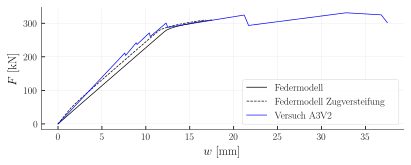

In [17]:
# | label: fig-fwa3v2
# | fig-cap: "Last-Verformungs-Verlauf am Punkt $w_1$ mit dem Federmodell und den Versuchsmessungen"


w_calc_a3v2 = modell_A3V2["eZ_1 [mm]"] * -1
F_calc_a3v2 = modell_A3V2["Lpa"] * F_a3v2_model

w_calc_a3v2_zugversteift = modell_A3V2_zugversteift["eZ_1 [mm]"] * -1
F_calc_a3v2_zugversteift = modell_A3V2_zugversteift["Lpa"] * F_a3v2_model


plt.plot(w_calc_a3v2, F_calc_a3v2, color="black", label="Federmodell")
plt.plot(
    w_calc_a3v2_zugversteift,
    F_calc_a3v2_zugversteift,
    color="black",
    linestyle="dashed",
    label="Federmodell Zugversteifung",
)

plt.plot(
    w_1_versuch_A3V2 - w_1_versuch_A3V2[0],
    F_A_versuch_A3V2,
    color="blue",
    label="Versuch A3V2",
)
plt.xlabel("$w$ [mm]")
plt.ylabel("$F$ [kN]")
plt.legend()
plt.savefig("imgs/F_w_nachrechnung_A3V2.svg")
plt.show()

In [18]:
DF_A3V2_LS320 = pd.read_excel(
    "calcs/FEM/AxisVM/FEM_daten.xlsx", sheet_name="A3V2_Federmodell_maxlast"
)
x_array_A3V2 = np.linspace(0, 2620, len(DF_A3V2_LS320.iloc[:, 0]))

Der Verdrehungsverlauf in @fig-phi-max-a3v2 lässt sich ebenfalls direkt aus dem Modell exportieren. Durch die Ableitung des Verlaufs resultiert der Krümmungsverlauf, dargestellt in @fig-chi-max-a3v2.

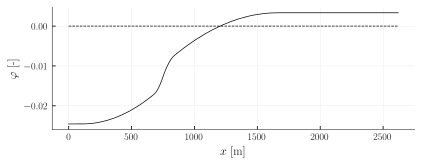

In [19]:
# | label: fig-phi-max-a3v2
# | fig-cap: "Verdrehungsverlauf aus dem Federmodell für die Höchstlast"


plt.plot(x_array_A3V2, DF_A3V2_LS320.iloc[:, -3], color="black")
plt.plot(x_array_A3V2, np.zeros(x_array_A3V2.shape), color="black", linestyle="dashed")

plt.xlabel("$x$ [m]")
plt.ylabel("$\\varphi$ [-]")
plt.show()

Der Krümmungsverlauf gibt Aufschluss über den Fliessbereich der Bewehrung, bzw. über den Steifigkeitenverlauf entlang der Stabachse.

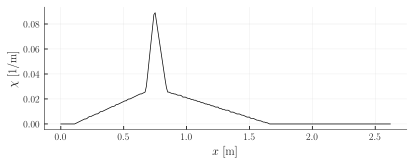

In [20]:
# | label: fig-chi-max-a3v2
# | fig-cap: "Berechneter Krümmungsverlauf aus dem Verdrehungsverlauf"


chi_a3v2 = np.gradient(DF_A3V2_LS320.iloc[:, -3], 0.01)

plt.plot(x_array_A3V2 / 1000, chi_a3v2, color="black")
plt.ylabel("$\\chi$ [1/m]")
plt.xlabel("$x$ [m]")
plt.savefig("imgs/kruemmungsverlauf_A3V2_axis.svg")
plt.show()

In [21]:
A_s_staender = 3 * A_sw_A3V2
expr_A = sp.sympify("pi*D**2/4")

Diam_staender = sp.solve(sp.Eq(A_s_staender.magnitude, expr_A), "D")[1].evalf(5) * mm

In [22]:
A_s_zuggurt = 2262 * mm**2

Diam_zuggurt = sp.solve(sp.Eq(A_s_zuggurt.magnitude, expr_A), "D")[1].evalf(5) * mm
# display_eq('/oslash_zuggurt',Diam_zuggurt.evalf(3))

{{<pagebreak>}}

## Vierpunktbiegeversuch

Der Vierpunktbiegeversuch ist aus dem Paper @tue_einfluss_2019 entnommen. Auffallend bei diesem Versuch ist die niedrig gehaltene Schubbewehrung. Dazu
sind in Längsrichtung Stäbe mit unterschiedlicher Güte verlegt. 

![Bewehrungslayout des Versuchs SV14, Zeichnung entnommen aus @gitz_ansatze_2024](../imgs/versuchsskizze_14.svg){#fig-versuchsskizze-SV14}


Der Querschnitt ist in der @fig-QS-SV14 gezeigt. Die Druckbewehrung wird vernachlässigt.

![Querschnitt des Versuchs SV14, Zeichnung entnommen aus @gitz_ansatze_2024](../imgs/QS_Versuch14.svg){#fig-QS-SV14}

Das statische System ist in der @fig-system-SV14 gezeigt. Auch hier wird das Eigengewicht, wie im Versuch A3V2, vernachlässigt. Die gemessene und rechnerisch bestimmte Verformung gelten für den Mittelspunkt, beschrieben mit $w_1$.

![Statisches System des Versuchs SV14, Zeichnung entnommen aus @gitz_ansatze_2024](../imgs/statisches_system_14.svg){#fig-system-SV14}






### Drehfedercharakteristik

Als Grundlage für die Drehfedercharakteristik gilt die Momenten-Krümmungs-Beziehung. Für den Querschnitt des Versuchs SV14 gilt die Beziehung gemäss @fig-mchi_sv14. Für detaillierte Berechnungen ist die Vorarbeit @gitz_ansatze_2024 zu konsultieren.

In [23]:
# Read the text file using numpy
M_SV14_array = np.loadtxt("docs/M_SV14.txt") * N * m
chi_SV14_array = np.loadtxt("docs/chi_SV14.txt") / m
chi_SV14_zugversteifung_1_array = chi_SV14_array.copy()
chi_SV14_zugversteifung_1_array[2] = chi_SV14_array[2] - 0.000779 / m
chi_SV14_zugversteifung_1_array[3] = chi_SV14_array[3] - 0.000779 / m
chi_SV14_zugversteifung_1_array[4] = chi_SV14_array[4] - 0.000779 / m

c:\Users\Pascal Gitz\miniconda3\envs\calcs11\Lib\site-packages\matplotlib\cbook.py:1345: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return np.asarray(x, float)


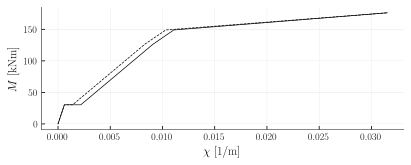

In [24]:
# | label: fig-mchi_sv14
# | fig-cap: "Momenten-Krümmungs-Beziehung des Vierpunktbiegeversuchs, übernommen aus @gitz_ansatze_2024"


chi_SV14_interpolated = np.linspace(0, max(chi_SV14_array), 1000)
# Linear interpolation in M_array
M_SV14_interpolated = np.interp(chi_SV14_interpolated, chi_SV14_array, M_SV14_array)

M_SV14_1_interpolated = np.interp(
    chi_SV14_interpolated, chi_SV14_zugversteifung_1_array, M_SV14_array
)
# Plot the interpolated data


# Plot the interpolated data
plt.plot(chi_SV14_interpolated, M_SV14_interpolated.to(kN * m), color="black")
plt.plot(
    chi_SV14_interpolated,
    M_SV14_1_interpolated.to(kN * m),
    color="black",
    linestyle="dashed",
    label="Zugversteifung",
)


# plt.fill_between(chi_SV14_interpolated, M_SV14_interpolated / 10**3, color="black", alpha=0.1)
plt.xlabel("$\\chi$ [1/m]")
plt.ylabel("$M$ [kNm]")
plt.savefig("imgs/M_chi_SV14.svg")

plt.show()

### Versatzmass

In diesem Kapitel wird das Versatzmass bestimmt. Bzw. im Vergleich mit der Vertiefungsarbeit @gitz_ansatze_2024 berichtigt. Es wird vom Versuch lediglich die starke Seite betrachtet, da durch Verstärkungsmassnahmen diese bis zum Versagen gebracht wird.

In [25]:
%%render params

V_exp_sv14 = (105 *kN)
z_SV14 = (359 * mm)
Diam_sw_SV14 = (4.3 * mm)
b_w_SV14 = (170 * mm)
S_sw_SV14 = (150 * mm)
f_su_SV14 = 657*N/mm**2
theta_c3_SV14 = (23.5*deg)


<IPython.core.display.Latex object>

Mit den Parametern, bzw. der Neigung der Betondruckdiagonale resultiert der nötige Querkraftwiderstand.

In [26]:
%%render 1

A_sw_SV14 = 2 * (Diam_sw_SV14 / 2) ** 2 * pi
a_sw_SV14 = (A_sw_SV14 / S_sw_SV14).to(mm**2/m)
V_Rd_SV14 = (a_sw_SV14 * z_SV14 * f_su_SV14 /tan(theta_c3_SV14)).to(kN)


<IPython.core.display.Latex object>

Die Spannungsfeldeinteilung ist in der @fig-spannungsfelder_sv14 gezeigt. Die Feldneigung ist näherungsweise an die berechnete Neigung angepasst.

![Einteilung in Spannungsfelder](../imgs/SV14_spannungsfelder.svg){#fig-spannungsfelder_sv14}

Wird nun Gleichgewicht an den entsprechenden Spannungsfeldern ausgeübt, so lässt sich der Zug- und Druckkraftverlauf bestimmen.

![Schnittkörperdiagramm des zentrierten Fächers](../imgs/SV14_skd_1.svg){#fig-skd_1_spannungsfelder_sv14}


In [27]:
%%render 
F_B = (105*kN)
F_A = V_exp_sv14
F_inf_1 = F_B * z_SV14/tan(theta_c3_SV14)/2 / z_SV14
F_sup_1 = F_inf_1

f_sw_1 = (F_B / z_SV14/tan(theta_c3_SV14)).to(kN/m)


<IPython.core.display.Latex object>


![Schnittkörperdiagramm des Parallelfelds](../imgs/SV14_skd_2.svg){#fig-skd_2_spannungsfelder_sv14}


In [28]:
%%render 

F_inf_2 = F_B * 3/2*z_SV14/tan(theta_c3_SV14) / z_SV14
F_sup_2 = F_inf_2

f_sw_2 = (F_B / z_SV14/tan(theta_c3_SV14)).to(kN/m)


<IPython.core.display.Latex object>


![Schnittkörperdiagramm des zentrierten Fächers 2](../imgs/SV14_skd_3.svg){#fig-skd_3_spannungsfelder_sv14}

In [29]:
%%render 
F_inf_3 = F_B * 2*z_SV14/tan(theta_c3_SV14) / z_SV14
F_sup_3 = F_inf_3

<IPython.core.display.Latex object>

In [30]:
def __F_sup_1(theta):
    return F_B * z_SV14/tan(theta) / z_SV14

def __F_sup_2(x):
    return F_B * (z_SV14/tan(theta_c3_SV14) + x) / z_SV14

def __F_sup_3(x):
    array = np.ones(x.shape)
    val = F_B * 2 * z_SV14 / tan(theta_c3_SV14) / z_SV14
    return val*array

theta_c3_SV14_array = np.linspace(90*deg, theta_c3_SV14, 100)


c:\Users\Pascal Gitz\miniconda3\envs\calcs11\Lib\site-packages\numpy\ma\core.py:2359: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  a = np.array(a, copy=False, subok=True)


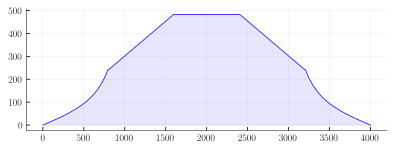

In [31]:
x_sup_sv14 = np.linspace(0,4000*mm, 500)

F_sup_array_sv14 = np.concatenate(
    (
    __F_sup_1(theta_c3_SV14_array).magnitude,
    __F_sup_2(np.linspace(0,z_SV14/tan(theta_c3_SV14),100)).magnitude,
    __F_sup_3(np.linspace(0,1000*mm,100)).magnitude,
    np.flip(__F_sup_2(np.linspace(0,z_SV14/tan(theta_c3_SV14),100)).magnitude),
    np.flip(__F_sup_1(theta_c3_SV14_array).magnitude),
    ),
    axis=0
)


# F_inf_array_sv14 = np.concatenate(
#     (
        
#     )

# )
                                  



plt.plot(x_sup_sv14, F_sup_array_sv14, color='blue')
plt.fill_between(x_sup_sv14, F_sup_array_sv14, color="blue", alpha=0.1)
plt.show()


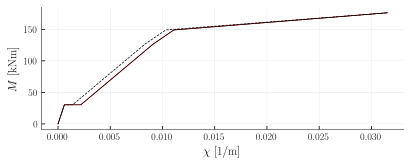

In [32]:
# | label: fig-mchi_sv14_versatz
# | fig-cap: "Momenten-Krümmungs-Beziehung des Vierpunktbiegeversuchs mit Versatzmass"


plt.plot(
    chi_SV14_interpolated,
    M_SV14_interpolated.to(kN * m),
    color="red",
    label="Versetzt",
)

# Plot the interpolated data
plt.plot(chi_SV14_interpolated, M_SV14_interpolated.to(kN * m), color="black")
plt.plot(
    chi_SV14_interpolated,
    M_SV14_1_interpolated.to(kN * m),
    color="black",
    linestyle="dashed",
    label="Zugversteifung",
)


# plt.fill_between(chi_SV14_interpolated, M_SV14_interpolated / 10**3, color="black", alpha=0.1)
plt.xlabel("$\\chi$ [1/m]")
plt.ylabel("$M$ [kNm]")
plt.savefig("imgs/M_chi_SV14.svg")

plt.show()

### Wegfedercharakteristik

#### Schiebung

Die Wegfedercharakteristik basiert auf der Spannungsfeldmodellierung gemäss der @fig-spannungsfelder_sv14


![Einteilung in Spannungsfelder des Versuchs SV14, Zeichnung entnommen aus @gitz_ansatze_2024](../imgs/spannungsfelder_sv14.svg){#fig-spannungsfelder_sv14}

Die Einteilung in Spannungsfelder ermöglicht die Bestimmung der mitwirkenden Schubbewehrung beim Versagen des Querschnitts. Die Neigung des Feldes ist so gewählt damit der Querkraftwiderstand der Schubbewehrung der Traglast des Systems entspricht.


In [33]:
sigma_w_SV14 = np.array([0.0, 550, 657]) * N / mm**2

c:\Users\Pascal Gitz\miniconda3\envs\calcs11\Lib\site-packages\matplotlib\cbook.py:1345: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return np.asarray(x, float)


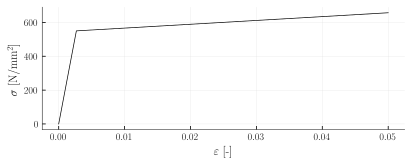

In [34]:
# | label: fig-sigma-epsilon-SV14
# | fig-cap: "Spannungs-Dehnungs-Beziehung der Schubbewehrung, übernommen aus @gitz_ansatze_2024"


epsilon_w_SV14 = np.array([0.0, 550 / 205000, 0.05])

plt.plot(epsilon_w_SV14, sigma_w_SV14, color="black")
# plt.fill_between(to_float(epsilon_w_SV14), to_float(sigma_w_SV14) / 1000**2, color="black", alpha=0.1)
plt.xlabel("$\\varepsilon$ [-]")
plt.ylabel("$\\sigma$ [N/mm$^2$]")
plt.show()

Folgend sind die Parameter zur Bestimmung der Wegfedercharakteristik in vertikaler Richtung gezeigt.

In [35]:
%%render params



E_sw_SV14 = 205000 * N / mm**2
E_sh_SV14 = (sigma_w_SV14[-1] - sigma_w_SV14[-2]) / (epsilon_w_SV14[-1] - epsilon_w_SV14[-2])



<IPython.core.display.Latex object>

Die Querschnittsfläche der Schubbewehrung und der Bewehrungsgehalt bestimmt sich zu:

In [36]:
%%render 2


rho_sw_SV14 = (a_sw_SV14 / b_w_SV14).to(percent)

<IPython.core.display.Latex object>

In [37]:
# def epsilon_c(q, sigma_sy, as_w, theta, b_w, E_c, z):
#     return ((q + sigma_sy*as_w) / (np.sin(theta)**2 * b_w * E_c)) * z/np.tan(theta)


# epsilon_c_SV14 = epsilon_c(0, sigma_w_SV14, a_sw_SV14, theta_c3_SV14, b_w_SV14, 30000*N/mm**2, z_approx_SV14)


epsilon_SV14 = epsilon_w_SV14

In [38]:
F_w_SV14 = sigma_w_SV14 * a_sw_SV14 * z_SV14 * sp.cot(theta_c3_SV14)

E_s_SV14 = sigma_w_SV14 / epsilon_SV14

c:\Users\Pascal Gitz\miniconda3\envs\calcs11\Lib\site-packages\pint\facets\plain\quantity.py:976: RuntimeWarning: invalid value encountered in divide
  magnitude = magnitude_op(self._magnitude, other_magnitude)


Der Reduktionsfaktor bestimmt sich zu:

In [39]:
%%render symbolic

gamma_E_SV14 = (z_SV14 * 1/tan(theta_c3_SV14) / l_element).to(los)


<IPython.core.display.Latex object>

In [40]:
%%render params 0

gamma_E_SV14

<IPython.core.display.Latex object>

In [41]:
u_sw_SV14 = epsilon_SV14 * z_SV14 / gamma_E_SV14

Die @fig-wegfeder-schub-sv14 zeigt das Kraft-Verformungs-Verhalten für die Gelenke des Stabmodells in vertikaler Richtung.

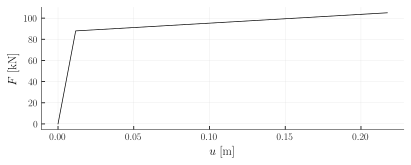

In [42]:
# | label: fig-wegfeder-schub-sv14
# | fig-cap: "Berechnete Wegfedercharakteristik des Schubgelenks vom Versuch SV14"


plt.plot(u_sw_SV14, F_w_SV14.to(kN), color="black")
# plt.fill_between(u_sw_SV14.magnitude, F_w_SV14.magnitude, color="black", alpha=0.1)
plt.xlabel("$u$ [m]")
plt.ylabel("$F$ [kN]")
plt.show()

In [43]:
# Read the Excel file
modell_SV14 = pd.read_excel(
    "calcs/FEM/AxisVM/FEM_daten.xlsx", sheet_name="SV14_Federmodell"
)
modell_SV14_zugversteift = pd.read_excel(
    "calcs/FEM/AxisVM/FEM_daten.xlsx", sheet_name="SV14_Federmodell_zugversteift"
)

F_SV14_model = 110

### Versuchsvergleich

Mit den bestimmten Federcharakteristiken kann die Biegelinie des Systems ermittelt werden unter Berücksichtigung der Schub- und Biegeverformungen auf nicht-linearen Grundlagen. Die @fig-l-w-sv14 zeigt das Last-Verformungs-Diagramm des Systems am Punkt $w_1$. Der Verformungsverlauf zeigt Abweichungen zu den gemessenen Resultate. Dies ist auf das Unterschlagen der Längszugkraft aus Querkraft zurückzuführen.

In [44]:
# Versuch Tue


w_1_versuch_SV14 = np.array(
    [
        0,
        0.28571428571428825,
        0.44642857142857295,
        0.5000000000000027,
        0.767857142857145,
        1.2500000000000018,
        3.3392857142857153,
        5.750000000000002,
        6.875000000000002,
        9.178571428571432,
        13.25,
        16.78571428571429,
        20.85714285714286,
        24.28571428571429,
        28.035714285714292,
        31.571428571428577,
        33.392857142857146,
        35.160714285714285,
        37.410714285714285,
    ]
)

F_A_versuch_SV14 = np.array(
    [
        0,
        5.315436241610726,
        7.087248322147644,
        8.859060402684563,
        11.516778523489918,
        14.322147651006702,
        20.375838926174495,
        28.791946308724818,
        33.221476510067106,
        41.63758389261744,
        57.583892617449656,
        69.54362416107382,
        78.40268456375838,
        84.60402684563758,
        92.57718120805369,
        99.51677852348993,
        102.02684563758389,
        103.6510067114094,
        104.53691275167785,
    ]
)

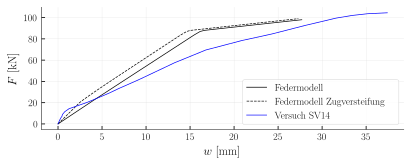

In [45]:
# | label: fig-l-w-sv14
# | fig-cap: "Last-Verformungs-Verlauf am Punkt $w_1$, für das Federmodell und den Versuch"


w_calc_SV14 = modell_SV14["eZ_1 [mm]"] * -1
F_calc_SV14 = modell_SV14["Lpa"] * F_SV14_model

w_calc_SV14_zugversteift = modell_SV14_zugversteift["eZ_1 [mm]"] * -1
F_calc_SV14_zugversteift = modell_SV14_zugversteift["Lpa"] * F_SV14_model


plt.plot(w_calc_SV14, F_calc_SV14, color="black", label="Federmodell")
plt.plot(
    w_calc_SV14_zugversteift,
    F_calc_SV14_zugversteift,
    color="black",
    linestyle="dashed",
    label="Federmodell Zugversteifung",
)

plt.plot(
    w_1_versuch_SV14 - w_1_versuch_SV14[0],
    F_A_versuch_SV14,
    color="blue",
    label="Versuch SV14",
)


plt.xlabel("$w$ [mm]")
plt.ylabel("$F$ [kN]")
plt.legend()
plt.savefig("imgs/F_w_nachrechnung_SV14.svg")
plt.show()

